In [1]:
# Install Library

!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 7.0 MB/s 
     |████████████████████████████████| 743 kB 50.7 MB/s 
     |████████████████████████████████| 4.9 MB 8.3 MB/s 
     |████████████████████████████████| 86 kB 1.1 MB/s 
     |████████████████████████████████| 1.1 MB 29.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=5a8de834a1b5f71aaa02038ab80d0925194eb6e92252b17c005f10ee8ae9ce8d
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=1359fad3b168997d227d13104f187e628bfbc668663c68478ddcc003c0d460af
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [59]:
# Import Library

import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections
%config InlineBackend.figure_format='retina'

In [66]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [67]:
# Connect to Google drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [68]:
df = pd.read_csv("/content/gdrive/MyDrive/BAD7105-CRM-Analytics/HW07 Voice of Customer/Wongnai Reviews - Small.csv")

In [71]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


In [70]:
df.shape


(300, 2)

**Step 1 - document embedding and dimension reduction**

In [8]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [9]:
embed_comments_array.shape

(300, 512)

In [10]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [11]:
umap_embed_comments_array.shape

(300, 50)

**Step 2 - document clustering using KMeans**

<function matplotlib.pyplot.show>

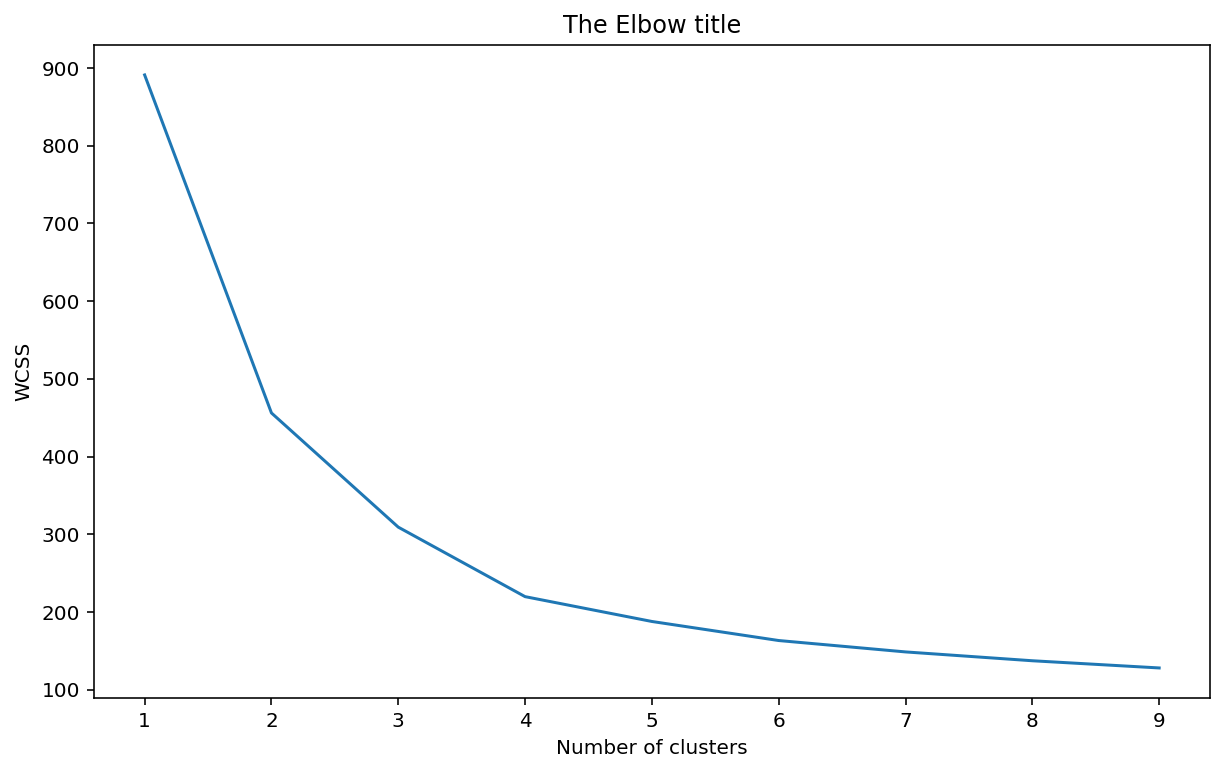

In [77]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.figure(figsize=(10,6))
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow.png',dpi=300)
plt.show

In [13]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [14]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [15]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
2,2,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [16]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [17]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [18]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [19]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [20]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [21]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [22]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก","ชานมไข่มุก","หัวหิน","ราชเทวี","มากกกกกกกกกกก","อเมซอน","ราชาติดี","เค้าดาว"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [23]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [24]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ทาน, 11), (ชอบ, ..."
1,1,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 10), (อร่อย, 9), (ทาน, 7), (ผม, 7), (รี..."
2,2,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กิน, 7), (อร่อย, 6), (ซอย, ..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 9), (ชานมไข่มุก, 9), (ทาน, 6), (ไข่มุก, ..."


In [53]:
df_kmeans['texts'][2]

'กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คสวัสดีเพื่อนๆสมาชิกนักรีวิวร้านอาหารชาวWongnaร้านส้มตำเจ๊พิมอยู่ถนนเลี่ยงตลาดหนองมนnเป็นร้ตอนเย็นๆหน่อยถ้าลงจากรถไฟฟ้าราชเทวีแล้วเดินย้อแมทช์นี้ที่หัวหินระหว่างที่ยังตกลงว่าทานกลมีคนแนะนำมาว่าต้องร้านนี้nเลยขอลองสักหน่อยไร้านตกแต่งน่ารักมากสไตล์นั่งอยู่ในบ้านก็จะมีขร้านอาหารเรื่อนปั้นหยาที่จอดรถกว้างขวางสะดวกสร้านอาหารไทยฟิวชั่นอร่อยสะอาดแต่ราคาสูงไปนิสาระพัดยำแบบแซ่บๆราคาไม่แพงnnร้านยำแซ่บสาเป็นร้านที่ได้ผักเยอะมากกกกกกกกกกกอร่อยคุ้มราร้านก๋วยเตี๋ยวเป็นร้านเก่าแก่ครองใจคนชลบุร้านเชฟมดรอบนี้มาจัดเป็นรอบที่สองหลังจากถูกใจริงๆจะไปกินร้านอื่นครับที่อยู่ในซอยเดียวกันแมีใครทำงานหรืออาศัยในย่านธุรกิจอย่างสุขุมวิทบ้โดยส่วนตัวแล้วไปทานที่ร้านแบล๊กแคนยอนที่สาขารามาถึงเมืองชลอีกครั้งค่าจาไปพัทยาแต่มอเตอร์เวร้านขายเป็ดห่านพะโล้เก่าแก่เขาเคลมว่าไม่มีสาขมีทั้งอาหารไทยและอาหารอีสานให้เลือกทานเมนูหลาขับรถเข้ามาในซอยโรงพยาบาลสมิติเวช(สุขุมวิทร้านกินดื่มแบบญี่ปุ่นหรืออิซากายะเป็นร้านอาหร้านนี้โฆษณาว่ามีเบียร์แช่เย็นเป็นวุ้นขายด้วอาหารอร่อยหลากหลายเมนูส้มตำอ

In [54]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ทาน', 11), ('ชอบ', 8), ('คาเฟ่', 6), ('กิน', 6), ('แวะ', 6), ('น่ารัก', 5), ('น', 5), ('นั่ง', 5)]

Cluster ID : 1

Most common words include : [('กิน', 10), ('อร่อย', 9), ('ทาน', 7), ('ผม', 7), ('รีวิว', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('กก', 5), ('อาหาร', 4)]

Cluster ID : 2

Most common words include : [('ร้านอาหาร', 11), ('กิน', 7), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4), ('ส้มตำ', 4)]

Cluster ID : 3

Most common words include : [('ชา', 9), ('ชานมไข่มุก', 9), ('ทาน', 6), ('ไข่มุก', 5), ('นม', 5), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('รีวิว', 3), ('ลอง', 3)]



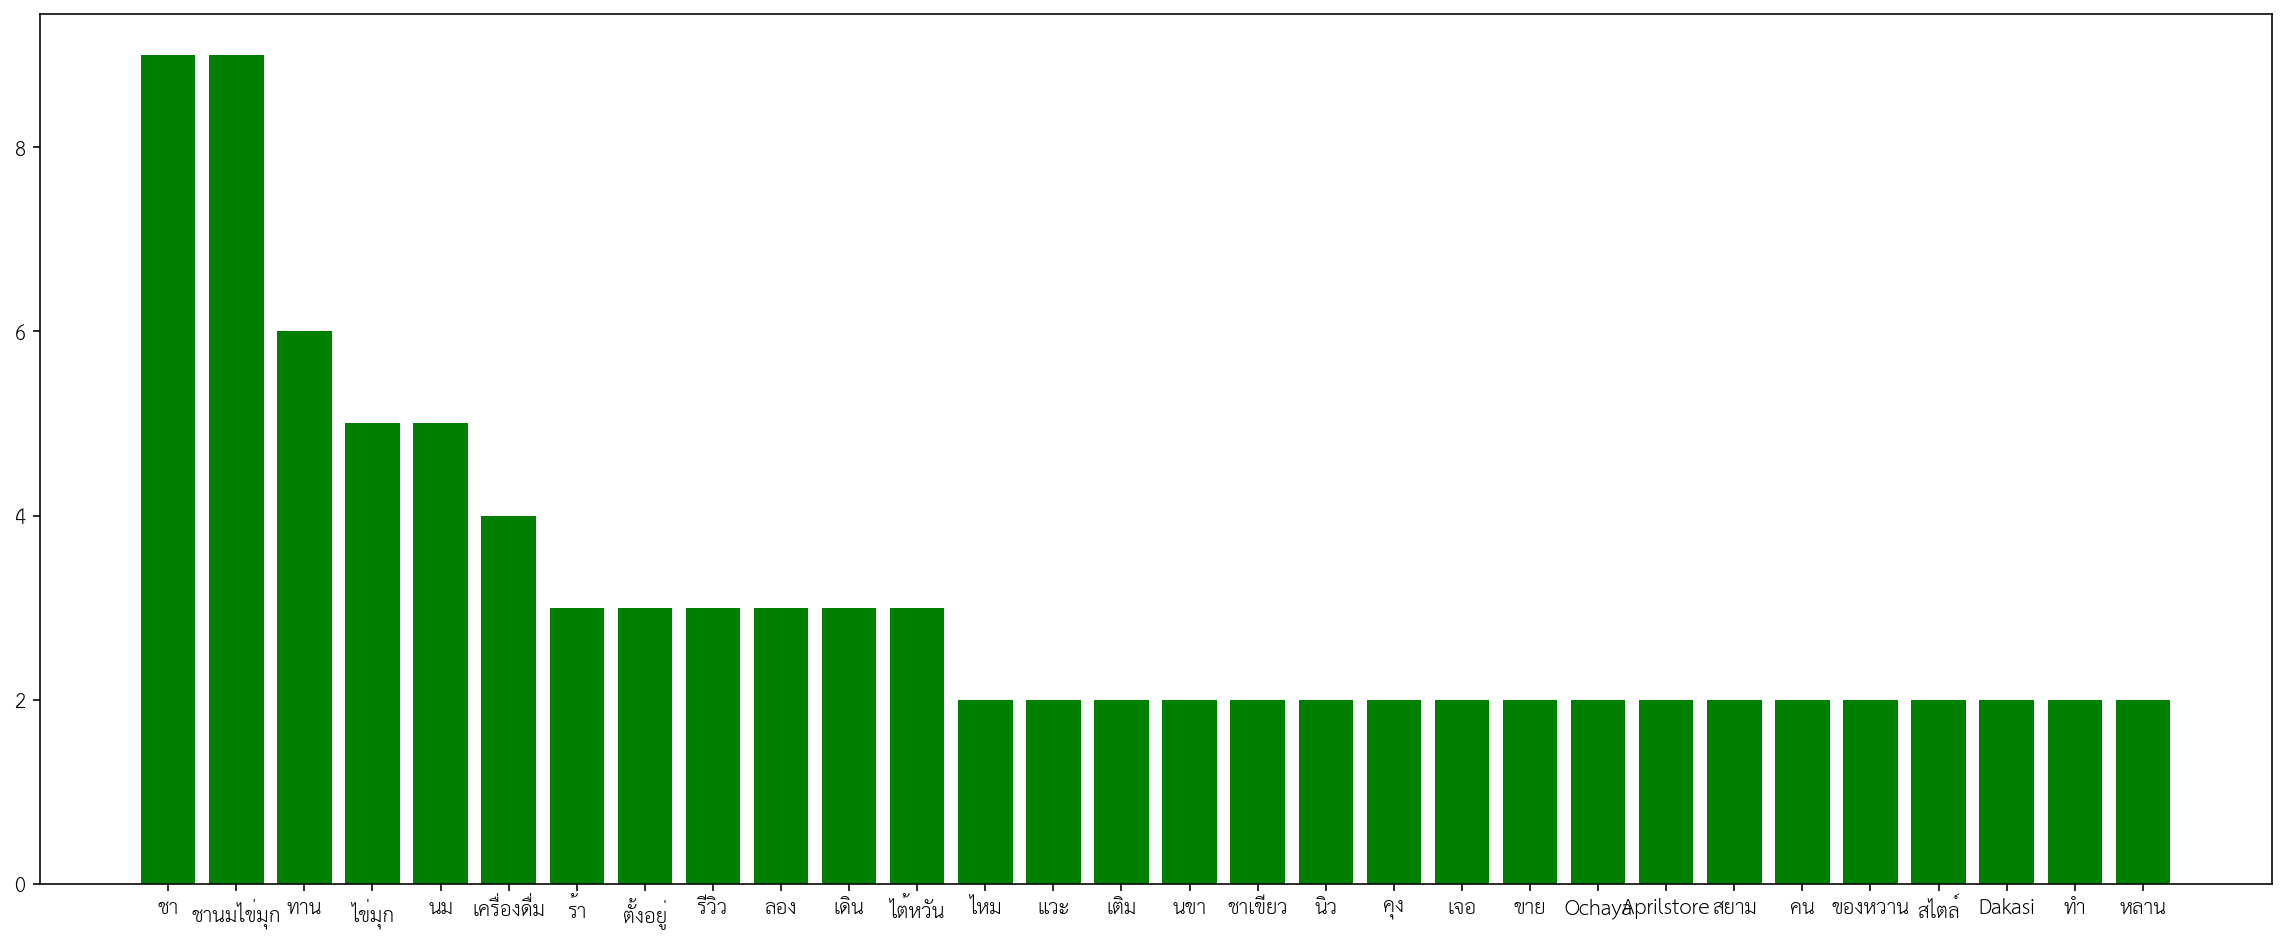

In [113]:
## Visualization
# import matplotlib as mpl
# mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
# mpl.rc('font', family='TH Sarabun New')


# top20 = df_kmeans['texts_count'][3][:30]
# plt.figure(figsize=(20,8))
# plt.bar(range(len(top20)), [val[1] for val in top20], align='center',color='green')
# plt.xticks(range(len(top20)), [val[0] for val in top20])
# plt.savefig('wordcount3_bar.png',dpi=300)
# plt.show()

In [ ]:
# Font Thai
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

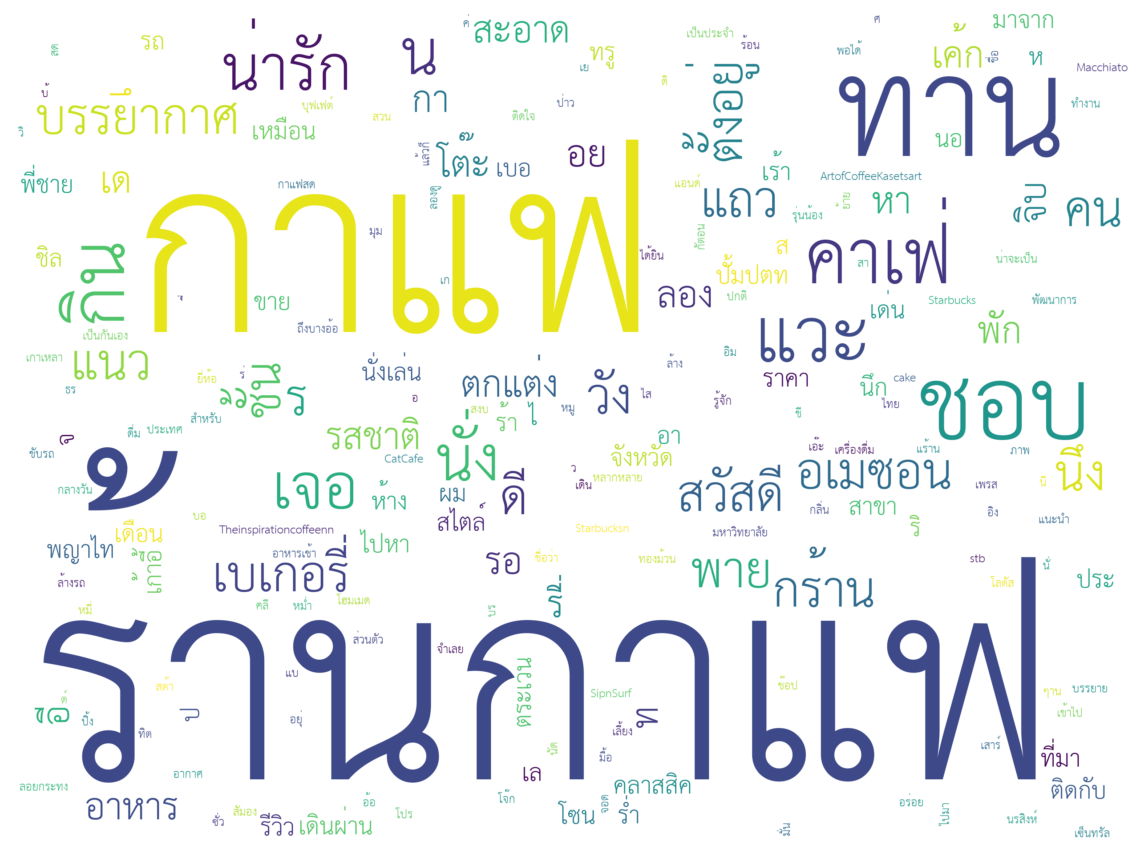

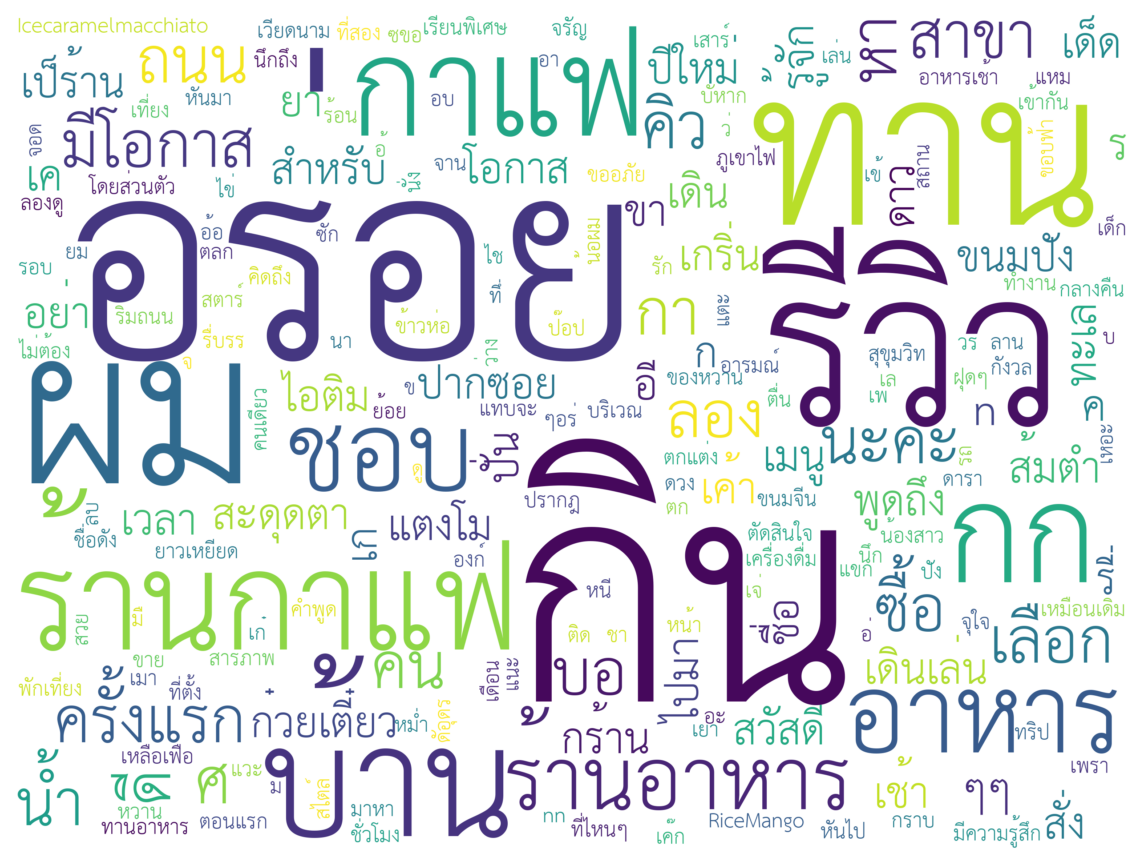

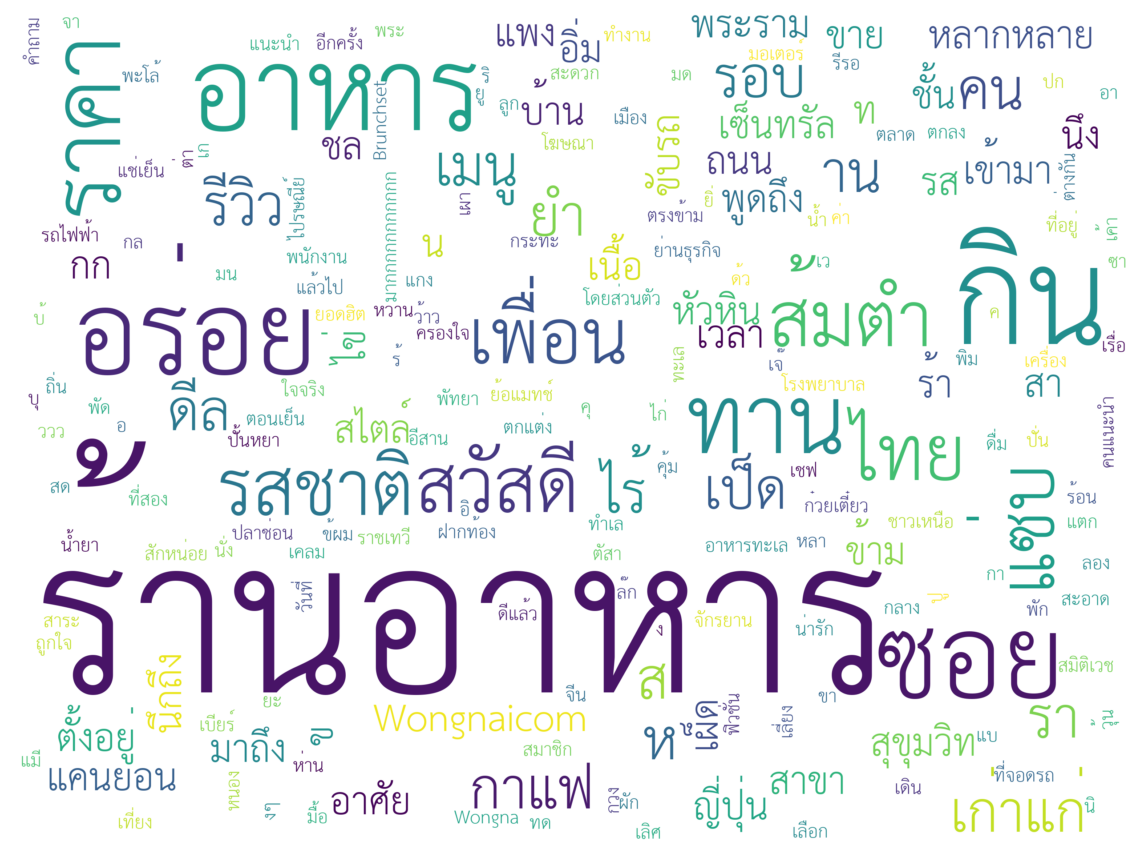

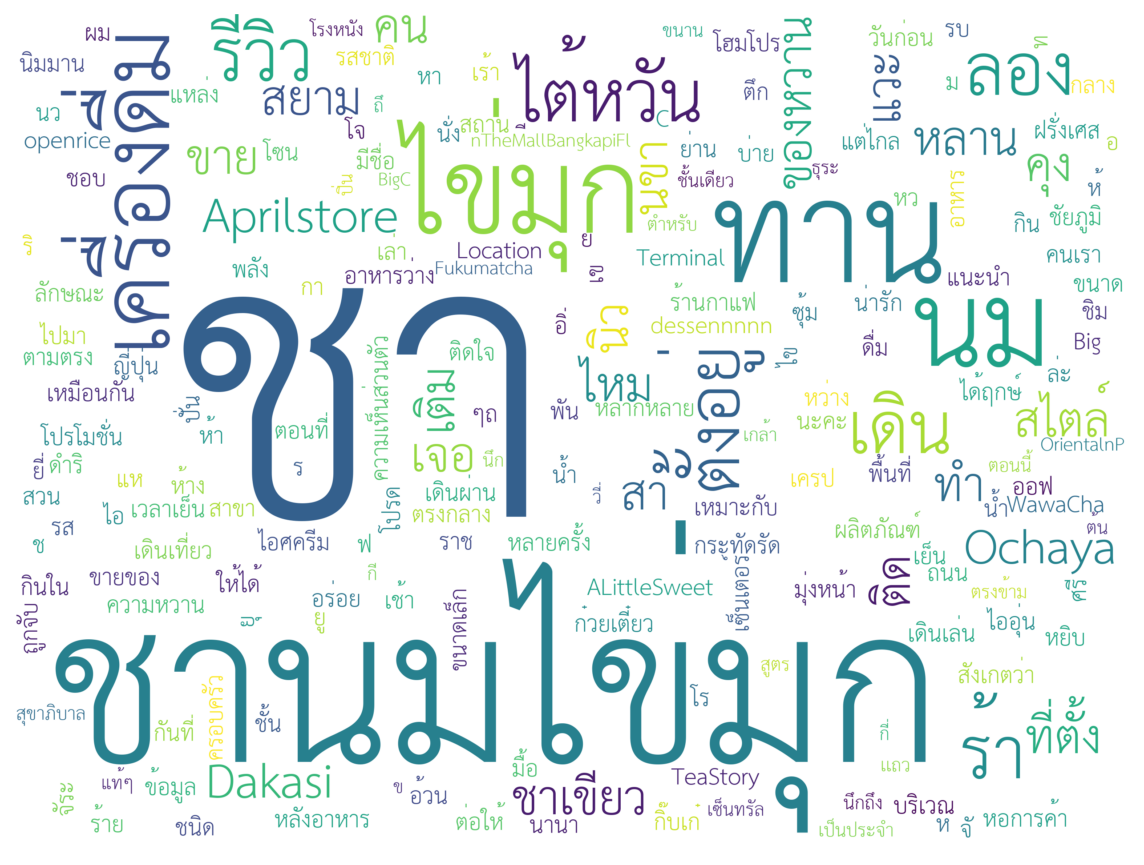

In [110]:
## Visualization
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# for x in range(4):
#   text_list = df_kmeans.loc[x,'texts_tokenized']
#   text = ''
#   for i in text_list:
#     text += i+' '
#   regexp = r"[\u0E00-\u0E7Fa-zA-Z']+"
#   re.findall(regexp, text, flags=re.UNICODE)

#   wordcloud = WordCloud(font_path='/content/gdrive/MyDrive/BAD7105-CRM-Analytics/HW07 Voice of Customer/thsarabunnew-webfont.ttf',
#                       relative_scaling = 1.0,
#                       min_font_size=4,
#                       background_color="white",
#                       width=1024,
#                       height=768,
#                       scale=3,
#                       font_step=1,
#                       collocations=False,
#                       regexp=r"[\u0E00-\u0E7Fa-zA-Z']+",
#                       margin=2
#                       ).generate(text)

#   plt.figure(figsize = (10, 10))
#   plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
#   plt.axis("off")
#   plt.savefig('wordcount{}'.format(x),dpi=300)
#   plt.show()

**Step 3 - result discussion**

1.   กลุ่ม0 เป็นกลุ่มรีวิวร้านอาหารโดยไม่กับเพื่อน
2.   กลุ่ม1 รีวิวเกี่ยวกับชา,ชานมไข่มุก
3.   กลุ่ม2 รีวิร้านเครื่องดื่มกาแฟ
4.   กลุ่ม3 รีวิวร้านคาเฟ้น่ารักๆๆ สำหรับคนชอบอะไรน่ารักๆ นั่งทานได้


